In [2]:
!pip install uv
# !uv pip install clip-by-openai --system

In [3]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
# Step 1: Load CLIP model and preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device=device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", device=device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
class TrainImageDataset(Dataset):
    def __init__(self, preprocessor, test_path, labels_csv_path):
        self.img_dir = test_path
        self.preprocessor = preprocessor
        self.image_names = pd.read_csv(labels_csv_path)  # Assumes a 'file_id' and 'class' column

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        file_id = self.image_names['file_id'].iloc[idx]
        class_name = self.image_names['class'].iloc[idx]
        img_path = os.path.join(self.img_dir, f"{file_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        image_transformed = self.preprocessor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        # Return a dictionary
        return {
            'image': image_transformed,
            'file_id': file_id,
            'class_name': class_name
        }

class TestImageDataset(Dataset):
    def __init__(self, preprocessor, test_path, labels_csv_path):
        self.img_dir = test_path
        self.preprocessor = preprocessor
        self.image_names = pd.read_csv(labels_csv_path)  # Assumes a 'file_id' column

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        file_id = self.image_names['file_id'].iloc[idx]
        img_path = os.path.join(self.img_dir, f"{file_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        image_transformed = self.preprocessor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        # Return a dictionary
        return {
            'image': image_transformed,
            'file_id': file_id
        }

In [6]:
# Update datasets to use CLIP preprocessing
train_ds = TrainImageDataset(
    preprocessor=processor,
    test_path="/kaggle/input/ucu-computer-vision-2024/train",
    labels_csv_path="/kaggle/input/ucu-computer-vision-2024/train.csv",
)

test_ds = TestImageDataset(
    preprocessor=processor,
    test_path="/kaggle/input/ucu-computer-vision-2024/test",
    labels_csv_path="/kaggle/input/ucu-computer-vision-2024/test.csv",
)
len(train_ds), len(test_ds)

(3597, 13115)

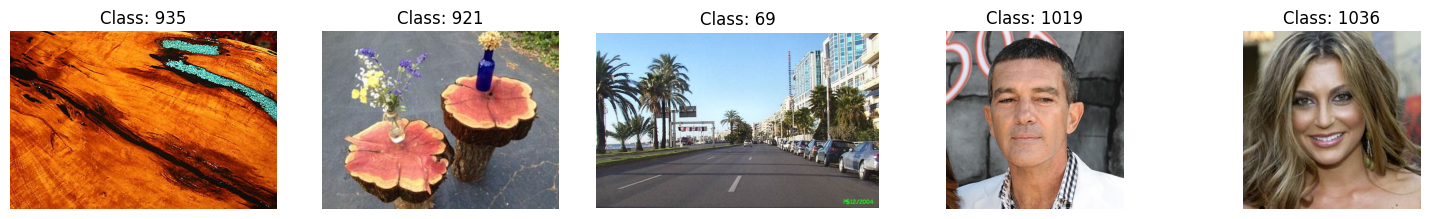

In [7]:
def display_images_by_class(labels_df, img_dir, num_images=5):
    sampled_classes = labels_df['class'].unique()
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(sampled_classes[:num_images]):
        sample_images = labels_df[labels_df['class'] == class_name].sample(1)
        for _, row in sample_images.iterrows():
            img_path = os.path.join(img_dir, f"{row['file_id']}.jpg")
            img = Image.open(img_path)

            plt.subplot(len(sampled_classes[:num_images]), num_images, i + 1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
train_df = pd.read_csv('/kaggle/input/ucu-computer-vision-2024/train.csv') 
display_images_by_class(train_df, '/kaggle/input/ucu-computer-vision-2024/train')

In [ ]:
# Step 2: Extract image embeddings
model.eval()

def extract_embeddings(dataset, model, device):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    embeddings = []
    file_ids = []

    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting embeddings"):
            images = batch["image"].to(device)
            file_ids.extend(batch["file_id"])

            # Forward pass through image encoder
            image_embeddings = model.get_image_features(pixel_values=images)
            image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)  # Normalize
            embeddings.append(image_embeddings)

    # Concatenate all embeddings
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings, file_ids

# Extract embeddings for train and test datasets
train_embeddings, train_file_ids = extract_embeddings(train_ds, model, device)
test_embeddings, test_file_ids = extract_embeddings(test_ds, model, device)

len(train_embeddings), len(test_embeddings)

Extracting embeddings:  24%|██▍       | 27/113 [01:40<05:35,  3.90s/it]

In [ ]:
import os

# Directory to save embeddings
output_dir = "/kaggle/working/ucu-hw-4-cv-clip-embeddings"
os.makedirs(output_dir, exist_ok=True)

# Convert embeddings to CPU
train_embeddings_cpu = train_embeddings.cpu()
test_embeddings_cpu = test_embeddings.cpu()

# Save embeddings and file IDs as .pt files
torch.save({'embeddings': train_embeddings_cpu, 'file_ids': train_file_ids}, 
           os.path.join(output_dir, "train_embeddings.pt"))

torch.save({'embeddings': test_embeddings_cpu, 'file_ids': test_file_ids}, 
           os.path.join(output_dir, "test_embeddings.pt"))

print(f"Train embeddings saved to {os.path.join(output_dir, 'train_embeddings.pt')}")
print(f"Test embeddings saved to {os.path.join(output_dir, 'test_embeddings.pt')}")

In [ ]:
# Load saved train embeddings
output_dir = "/kaggle/working/ucu-hw-4-cv-clip-embeddings"
train_data = torch.load(os.path.join(output_dir, "train_embeddings.pt"))
train_embeddings = train_data['embeddings']
train_file_ids = train_data['file_ids']

print(f"Loaded train embeddings shape: {train_embeddings.shape}")
print(f"Loaded train file IDs count: {len(train_file_ids)}")

# Load saved train embeddings
test_data = torch.load(os.path.join(output_dir, "test_embeddings.pt"))
test_embeddings = test_data['embeddings']
test_file_ids = test_data['file_ids']

print(f"Loaded test embeddings shape: {test_embeddings.shape}")
print(f"Loaded test file IDs count: {len(test_file_ids)}")


In [ ]:
# Step 3: Define distance-based distractor detection
from torch.nn.functional import cosine_similarity

def classify_distractors_with_cosine(test_embeddings, train_embeddings, contamination_rate=0.3):
    max_similarities = []
    
    for test_emb in test_embeddings:
        # Compute cosine similarity between this test embedding and all train embeddings
        similarities = cosine_similarity(test_emb.unsqueeze(0), train_embeddings, dim=1)
        # Store the maximum similarity for this test embedding
        max_similarities.append(similarities.max().item())
    
    # Convert to tensor for further processing
    max_similarities = torch.tensor(max_similarities)
    
    # Determine the threshold based on contamination rate
    sorted_similarities, _ = torch.sort(max_similarities, descending=True)
    threshold_index = int(len(sorted_similarities) * (1 - contamination_rate))
    threshold = sorted_similarities[threshold_index].item()
    
    # Classify as distractors if similarity is below the threshold
    distractor_mask = max_similarities < threshold
    
    return distractor_mask, threshold



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Range of contamination rates
contamination_rates = np.linspace(0.1, 0.5, 5)  # Test rates from 10% to 50%

thresholds = []
distractor_counts = []

for rate in tqdm(contamination_rates, "linear space search"):
    distractor_mask, threshold = classify_distractors_with_cosine(test_embeddings, train_embeddings, contamination_rate=rate)
    thresholds.append(threshold)
    distractor_counts.append(distractor_mask.sum().item())

# Plot
plt.figure(figsize=(8, 6))
plt.plot(contamination_rates, thresholds, label="Threshold")
plt.xlabel("Contamination Rate")
plt.ylabel("Threshold Value")
plt.title("Threshold vs. Contamination Rate")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(contamination_rates, distractor_counts, label="Distractor Count")
plt.xlabel("Contamination Rate")
plt.ylabel("Number of Distractors")
plt.title("Contamination Rate vs. Distractor Count")
plt.legend()
plt.show()


In [ ]:
train_df = pd.read_csv('/kaggle/input/ucu-computer-vision-2024/train.csv') 
test_df = pd.read_csv('/kaggle/input/ucu-computer-vision-2024/test.csv') 

In [ ]:
distractor_mask = classify_distractors_with_cosine(
    test_embeddings=test_embeddings,
    train_embeddings=train_embeddings,
    contamination_rate=0.3,
)

In [ ]:
distractor_mask_a = np.array(distractor_mask[0]).astype(int)
print(f"""Distractor filtering results: 
threshold is: {np.array(distractor_mask[1]):.2f} 
for contamination rate: {len(test_df.loc[distractor_mask_a]) / len(test_df):.2f}""")


In [ ]:
len(distractor_mask[0]), len(test_df), distractor_mask_a

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Step 3: Combine embeddings
train_labels = np.zeros(len(train_embeddings))
test_labels = np.ones(len(test_embeddings))

# Combine embeddings and labels
all_embeddings = torch.cat([train_embeddings, test_embeddings], dim=0).cpu().numpy()
all_labels = np.concatenate([train_labels, test_labels])

# Ensure distractor mask aligns with test embeddings
distractor_test_labels = np.concatenate([np.zeros(len(train_labels)), distractor_mask_a])

# Step 4: Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(all_embeddings)

# Step 5: Visualize
plt.figure(figsize=(12, 8))

# Plot test embeddings in the background
test_indices = np.where((all_labels == 1) & (distractor_test_labels == 0))
plt.scatter(tsne_results[test_indices, 0], tsne_results[test_indices, 1], 
            c="green", label="Test (Non-Distractor)", alpha=0.2, zorder=1)

# Plot train embeddings in the middle
train_indices = np.where(all_labels == 0)
plt.scatter(tsne_results[train_indices, 0], tsne_results[train_indices, 1], 
            c="blue", label="Train", alpha=0.2, zorder=2)

# Plot distractors on top
distractor_test_indices = np.where((all_labels == 1) & (distractor_test_labels == 1))
plt.scatter(tsne_results[distractor_test_indices, 0], tsne_results[distractor_test_indices, 1], 
            c="red", label="Distractors (Test)", alpha=0.2, zorder=3)

plt.title("t-SNE Visualization of Train, Test, and Distractors (Reordered Z-Axis)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


It's clear that most of the distructors are some classes added to the test set, but not "too-different" original classes from the train set. If we've had more time, we can use UMAP to select clusters which are not present in train embeddings. But for the sake of time savings, we'll use DBSCAN method with minimal adjustments to our basecode. 

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Combine train and test embeddings
all_embeddings = torch.cat([train_embeddings, test_embeddings], dim=0).cpu().numpy()
train_labels = np.zeros(len(train_embeddings))  # Train samples labeled as 0
test_labels = np.ones(len(test_embeddings))    # Test samples labeled as 1
all_labels = np.concatenate([train_labels, test_labels])

# Step 2: Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(all_embeddings)

# Step 3: Cluster with DBSCAN
clustering = DBSCAN(eps=1.0, min_samples=5).fit(tsne_results)
cluster_labels = clustering.labels_  # -1 indicates noise

# Step 4: Identify distractors
# Map train cluster labels
train_indices = np.where(all_labels == 0)[0]
train_clusters = set(cluster_labels[train_indices])

# Identify test samples not in train clusters
test_indices = np.where(all_labels == 1)[0]
distractor_indices = [
    idx for idx in test_indices if cluster_labels[idx] not in train_clusters
]

# Step 5: Visualize Clusters
plt.figure(figsize=(12, 8))

# Plot train embeddings
plt.scatter(tsne_results[train_indices, 0], tsne_results[train_indices, 1],
            c="blue", label="Train", alpha=0.2, zorder=2)

# Plot test embeddings
plt.scatter(tsne_results[test_indices, 0], tsne_results[test_indices, 1],
            c="green", label="Test (Non-Distractor)", alpha=0.2, zorder=1)

# Highlight distractors
plt.scatter(tsne_results[distractor_indices, 0], tsne_results[distractor_indices, 1],
            c="red", label="Distractors", alpha=0.2, zorder=3)

plt.title("t-SNE Clustering of Train and Test Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


Maybe the result is not ideal, since we can clearly see that some of the samples from test set, from the clusters which were identified by DBSCAN as distractors, in my opinion it looks conceptually better than simple cosine similarity approach. However, there could be more (although I suppose not many) samples just different from the train dataset, but I doubt they are actually distactors in their nature, but less simmilar examples of classes present in the train dataset.

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd

# Step 4: Predict top-5 classes for non-distractors (DBSCAN + Cosine Similarity) in batches
def predict_top_5_with_distractors_batched(image_embeddings, class_embeddings, distractor_array, test_file_ids, classes, batch_size=64):
    predictions = {}

    # Ensure embeddings are on the same device
    device = image_embeddings.device
    class_embeddings = class_embeddings.to(device)

    # Process in batches
    for batch_start in tqdm(range(0, len(test_file_ids), batch_size), desc="Processing Batches"):
        batch_end = min(batch_start + batch_size, len(test_file_ids))
        batch_indices = range(batch_start, batch_end)

        # Extract batch data
        batch_embeddings = image_embeddings[batch_indices]
        batch_distractors = distractor_array[batch_indices]
        batch_file_ids = test_file_ids[batch_start:batch_end]

        # Compute cosine similarity for the batch
        similarities = F.cosine_similarity(batch_embeddings.unsqueeze(1), class_embeddings.unsqueeze(0), dim=2)

        # Generate predictions for the batch
        for i, file_id in enumerate(batch_file_ids):
            # Get top-5 classes based on similarity
            top_4_indices = torch.topk(similarities[i], 4).indices.tolist()  # Top 4 from classes
            top_4_classes = [classes[j] for j in top_4_indices]

            if batch_distractors[i] == 1:  # If distractor, prepend -1
                predictions[file_id] = [-1] + top_4_classes
            else:  # Otherwise, just top-4 predictions
                predictions[file_id] = top_4_classes

    return predictions

# Step 5: Generate predictions using batch processing
classes = train_df['class'].unique()
batch_size = 512  # Adjust batch size to your memory constraints

test_predictions = predict_top_5_with_distractors_batched(
    test_embeddings,
    train_embeddings,
    distractor_mask,
    test_file_ids,
    classes,
    batch_size=batch_size
)

# Step 6: Save predictions for Kaggle submission
submission = []
for file_id, preds in test_predictions.items():
    submission.append({"file_id": file_id, "class": " ".join(map(str, preds))})

submission_df = pd.DataFrame(submission)

submission_file_path = "/kaggle/working/submission.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Kaggle submission file saved to: {submission_file_path}")
